In [1]:
# Install yfinance if not already installed
#!pip install yfinance

# Import necessary libraries
import yfinance as yahooFinance
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [2]:
# Fetch historical stock data
def get_stock_data(symbol, start_date, end_date):
    stock_data = yahooFinance.download(symbol, start=start_date, end=end_date)
    if stock_data.empty:
        raise ValueError(f'No data found for symbol {symbol} between {start_date} and {end_date}.')
    return stock_data

In [3]:
# Specify stock and date range
stock_symbol = 'NVDA'
stock_start_date = '2024-02-20'
stock_end_date = '2025-02-20'

# Get stock data
stock_data = get_stock_data(stock_symbol, stock_start_date, stock_end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
print(stock_data)

Price            Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                 
2024-02-20   69.432312   71.935600   67.714797   71.926600  704833000
2024-02-21   67.452881   68.868480   66.229229   67.986726  690298000
2024-02-22   78.515739   78.552724   74.198963   75.003735  865100000
2024-02-23   78.794655   82.370637   77.548007   80.767095  829388000
2024-02-26   79.069588   80.623148   78.482748   79.677409  503973000
...                ...         ...         ...         ...        ...
2025-02-12  131.139999  132.240005  129.080002  130.020004  160278600
2025-02-13  135.289993  136.500000  131.169998  131.559998  197430000
2025-02-14  138.850006  139.250000  135.500000  136.479996  195479600
2025-02-18  139.399994  143.440002  137.929993  141.270004  219176600
2025-02-19  139.229996  141.360001  137.220001  139.509995  167536000

[251 rows x 5 colum

In [5]:
# Data Preprocessing

# Handle Missing Data
stock_data = stock_data.ffill()

# Feature engineering
stock_data['Return'] = stock_data['Close'].pct_change()                 # Daily return
stock_data['Log_Return'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))  # Log return
stock_data['MA_7'] = stock_data['Close'].rolling(window=7).mean()     # 7-day moving average
stock_data['Volatility'] = stock_data['Close'].rolling(window=10).std() # 10-day volatility

# Drop rows with NaN values
stock_data.dropna(inplace=True)

# Select features and scale data
features = ['Close', 'Return', 'Log_Return', 'MA_7', 'Volatility']

scaler = MinMaxScaler()
scaled_stock_data = scaler.fit_transform(stock_data[features])

In [6]:
# Prepare data for LSTM by creating time steps
def prepare_data(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i: i + time_step])         # Sequence of time_step days
        y.append(data[i + time_step, 0])         # Target: Close price at time_step+1
    return np.array(X), np.array(y)

In [7]:
time_step = 30              # Number of previous time steps used for prediction
train_split = 0.8          # 80% data for training

# Prepare the data
X, y = prepare_data(scaled_stock_data, time_step)

# Split into train and test sets
train_size = int(len(X) * train_split)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
# Check shapes for LSTM compatibility
print("X_train shape:", X_train.shape)  # (samples, time_step, features)
print("y_train shape:", y_train.shape)  # (samples, 1)

X_train shape: (169, 30, 5)
y_train shape: (169,)


In [9]:
# Create LSTM Model
model_input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

model = Sequential()

# First LSTM layer with 100 units and return sequences for stacking another LSTM
model.add(LSTM(units=100, return_sequences=True, input_shape=model_input_shape))
model.add(Dropout(rate=0.3))  # Dropout to reduce overfitting

# Second LSTM layer with 50 units
model.add(LSTM(units=50))
model.add(Dropout(rate=0.3))

# Dense layer to produce the final output (predicted Close price)
model.add(Dense(units=1))

# Compile the model with Adam optimizer and Mean Squared Error loss
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\vnguy\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Train the LSTM Model
epochs = 100
batch_size = 16

# Train the model on training data and validate on test data
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.1519 - val_loss: 0.0350
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0324 - val_loss: 0.0224
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0195 - val_loss: 0.0144
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0233 - val_loss: 0.0123
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0160 - val_loss: 0.0131
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0175 - val_loss: 0.0128
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0181 - val_loss: 0.0133
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0175 - val_loss: 0.0126
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0207 - val_loss: 0.0157
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0149 - val_loss: 0.0144
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0198 - val_loss: 0.0130
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

In [11]:
# Predict Log_Return on the test data
predictions = model.predict(X_test)

# Inverse scaling to get actual price values for comparison
scaled_y_test = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), scaler.n_features_in_ - 1))], axis=1)
)[:, 0]

scaled_predictions = scaler.inverse_transform(
    np.concatenate([predictions, np.zeros((len(predictions), scaler.n_features_in_ - 1))], axis=1)
)[:, 0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


In [12]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(scaled_y_test, scaled_predictions))
print(f'Test RMSE: {rmse:.2f}')

Test RMSE: 6.46


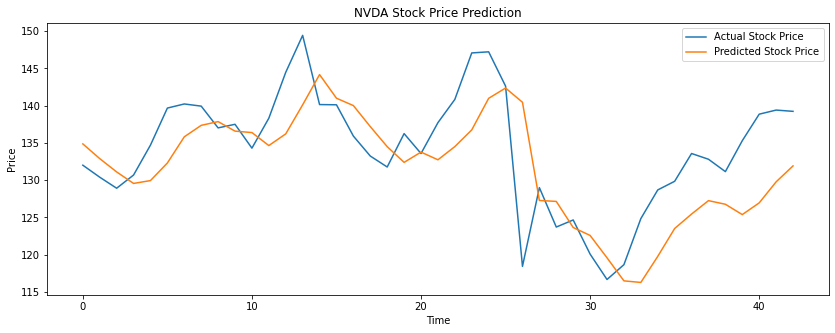

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(scaled_y_test, label='Actual Stock Price')
plt.plot(scaled_predictions, label='Predicted Stock Price')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.show()